Use data generated in pseudo_slant_3.ipynb for various slants, and see how well different corrections work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time
from scipy import integrate

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

import pickle

import capytaine as cpt
# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)
import copy

In [ ]:
with open("data/configs-with-corrections", "rb") as f:
  configurations = pickle.load(f)

In [2]:
# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError
  
  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime


In [3]:
def solve_prob(config, res, version):
  NMK = [100, 100, 100]
  a, d_in, d_out, heaving = config["a"], config["d_in"], config["d_out"], config["heaving"]
  d_prime, a_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = Problem(config["h"], d_prime, a_prime, heaving_prime, NMK_prime, config["m0"], config["rho"])
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  return prob, x

In [4]:
def d_wrt_r(config, r): # outine of body
  if config["d_in"][0] == 5: return 5
  elif r <= config["a"][0]: return config["d_in"][0]
  elif r <= config["a"][1]:
    slope = (config["d_out"][1] - config["d_in"][1])/(config["a"][1] - config["a"][0])
    return config["d_in"][1] + slope * (r - config["a"][0])
  else: # no depths here
    raise ValueError
  
def region_wrt_r(prob, r):
  region = 0
  for i in range(prob.boundary_count):
    if r <= prob.a[i]: return region
    else: region += 1
  return region

def sin_theta(config):
  delta_r = config["a"][1] - config["a"][0]
  delta_z = config["d_out"][0] - config["d_out"][1]
  return delta_r/(np.sqrt(delta_z ** 2 + delta_r ** 2))

In [5]:
# All hydro coefficients are in the capytaine convention for easy comparisons.

# In hydro 1, no correction is applied to find the value for slants.
def hydro1(prob, x):
  return prob.hydro_coeffs(x, "capytaine")

# In hydro 2, a sin(theta) correction is applied, the normal vector component in the heave direction.
def hydro2(config, prob, x):
  # recall that interior region is not heaving, so this is only applied to the heaving region
  am0, dp0 = hydro1(prob, x)
  st = sin_theta(config)
  return st * am0, st * dp0

# In hydro 3, the integral is along the true outline instead of the approximated outline,
# but dphi_h/d_z is assumed to be zero.
def hydro3(config, prob, x):
  cs = prob.reformat_coeffs(x)
  NMK = prob.NMK
  h = config["h"]
  d = prob.d

  # def phi_h_n_inner_func(n, r, z):
  #     return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.Z_n_i(n, z, 0)
  def phi_h_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.Z_n_i(m, z, i)
  def phi_p_i(d, r, z): # particular solution
      return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)

  # def v_z_inner_func(n, r, z):
  #     return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.diff_Z_n_i(n, z, 0)
  # def v_z_m_i_func(i, m, r, z):
  #     return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.diff_Z_n_i(m, z, i)
  def diff_z_phi_p_i(d, z): 
      return ((z+h) / (h - d))
  
  def integrand(r): # check this for other configurations
    region = region_wrt_r(prob, r)
    terms = range(prob.NMK[region])
    t1 = sum([phi_h_m_i_func(region, n, r, d_wrt_r(config, r)) for n in terms]) + phi_p_i(d[region], r, d_wrt_r(config, r))
    t2 = diff_z_phi_p_i(d[region], d_wrt_r(config, r))
    return t1 * t2 * r
  
  accumulator = 0
  for i in range(1, prob.boundary_count):
     inner_rad = prob.a[i - 1]
     outer_rad = prob.a[i]
     accumulator += integrate.quad(integrand, inner_rad, outer_rad, complex_func=True)[0]

  base = 2 * np.pi * accumulator

  # Capytaine convention
  added_mass = base.real * prob.rho
  damping = base.imag * prob.angular_freq(prob.m0) * prob.rho
  
  return added_mass, damping

# In hydro 4, the integral is along the true outline instead of the approximated outline,
# but dphi_h/d_z is not assumed to be zero, and is computed.
def hydro4(config, prob, x):
  cs = prob.reformat_coeffs(x)
  NMK = prob.NMK
  h = config["h"]
  d = prob.d

  # def phi_h_n_inner_func(n, r, z):
  #     return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.Z_n_i(n, z, 0)
  def phi_h_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.Z_n_i(m, z, i)
  def phi_p_i(d, r, z): # particular solution
      return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)

  # def v_z_inner_func(n, r, z):
  #     return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.diff_Z_n_i(n, z, 0)
  def v_z_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.diff_Z_n_i(m, z, i)
  def diff_z_phi_p_i(d, z): 
      return ((z+h) / (h - d))
  
  def integrand(r): # check this for other configurations
    region = region_wrt_r(prob, r)
    terms = range(prob.NMK[region])
    t1 = sum([phi_h_m_i_func(region, n, r, d_wrt_r(config, r)) for n in terms]) + phi_p_i(d[region], r, d_wrt_r(config, r))
    t2 = sum([v_z_m_i_func(region, n, r, d_wrt_r(config, r)) for n in terms]) + diff_z_phi_p_i(d[region], d_wrt_r(config, r))
    return t1 * t2 * r
  
  accumulator = 0
  for i in range(1, prob.boundary_count):
     inner_rad = prob.a[i - 1]
     outer_rad = prob.a[i]
     accumulator += integrate.quad(integrand, inner_rad, outer_rad, complex_func=True)[0]

  base = 2 * np.pi * accumulator

  # Capytaine convention
  added_mass = base.real * prob.rho
  damping = base.imag * prob.angular_freq(prob.m0) * prob.rho
  
  return added_mass, damping

# hydro 5 and 6 are 3 and 4 with a sin(theta) correction
def hydro5(config, prob, x):
  am0, dp0 = hydro3(config, prob, x)
  st = sin_theta(config)
  return st * am0, st * dp0

def hydro6(config, prob, x):
  am0, dp0 = hydro4(config, prob, x)
  st = sin_theta(config)
  return st * am0, st * dp0


In [ ]:
# for config in configurations:
#   for version in [1, 2, 3]:
#     config["v"+ str(version) + " probs"] = []
#     config["v"+ str(version) + " xs"] = []
#     for res in range(1, 26):
#       prob, x = solve_prob(config, res, version)
#       config["v"+ str(version) + " probs"].append(prob)
#       config["v"+ str(version) + " xs"].append(x)

/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=3.93107e-17): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=1.03553e-21): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=7.97778e-31): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=2.33232e-17): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=5.00693e-

In [6]:
def get_hydros(config, prob, x, style):
  if style == 1:
    return hydro1(prob, x)
  elif style == 2:
    return hydro2(config, prob, x)
  elif style == 3:
    return hydro3(config, prob, x)
  elif style == 4:
    return hydro4(config, prob, x)
  elif style == 5:
    return hydro5(config, prob, x)
  elif style == 6:
    return hydro6(config, prob, x)

# for config in configurations:
#   for version in [1, 2, 3]:
#     for hydro_style in [1, 3, 4]:
#       config["v"+ str(version) + " style" + str(hydro_style) + " AMs"] = []
#       config["v"+ str(version) + " style" + str(hydro_style) + " DPs"] = []
#       for res in range(1, 26):
#         prob = config["v"+ str(version) + " probs"][res - 1]
#         x = config["v"+ str(version) + " xs"][res - 1]
#         am, dp = get_hydros(config, prob, x, hydro_style)
#         config["v"+ str(version) + " style" + str(hydro_style) + " AMs"].append(am)
#         config["v"+ str(version) + " style" + str(hydro_style) + " DPs"].append(dp)
#     st = sin_theta(config)
#     config["v"+ str(version) + " style2 AMs"] = [st * val for val in config["v"+ str(version) + " style1 AMs"]]
#     config["v"+ str(version) + " style2 DPs"] = [st * val for val in config["v"+ str(version) + " style1 DPs"]]
#     config["v"+ str(version) + " style5 AMs"] = [st * val for val in config["v"+ str(version) + " style3 AMs"]]
#     config["v"+ str(version) + " style5 DPs"] = [st * val for val in config["v"+ str(version) + " style3 DPs"]]
#     config["v"+ str(version) + " style6 AMs"] = [st * val for val in config["v"+ str(version) + " style4 AMs"]]
#     config["v"+ str(version) + " style6 DPs"] = [st * val for val in config["v"+ str(version) + " style4 DPs"]]
#   print("Finished config " + config["name"])


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49550/1633643410.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapr, cmapg, cmapb = get_cmap('Reds'), get_cmap('Greens'), get_cmap('Blues')


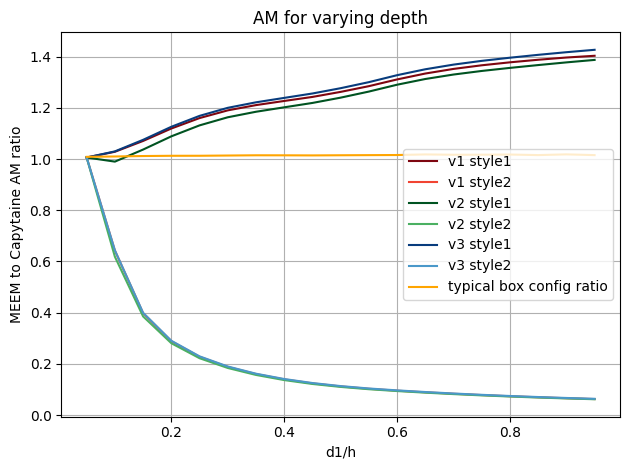

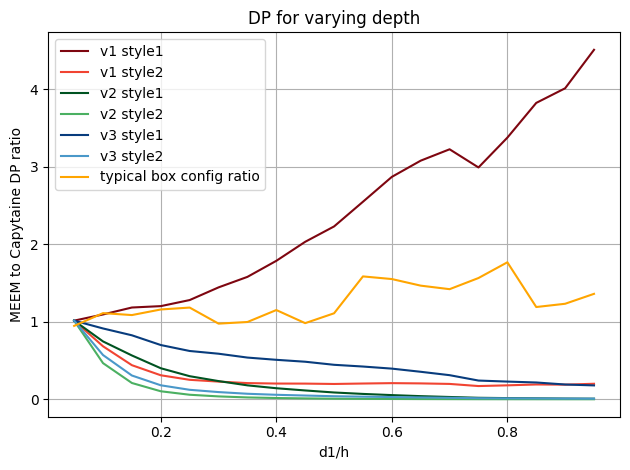

In [10]:
# Plot the highest res slant approximation vs slant for each approximation, for different configs.
def plot_wrt_depth(configurations, coefficient):
  # coefficient = "AM" or "DP"
  x = [i * 0.01 for i in list(range(5, 100, 5))]

  meem_box_values = [config["MEEM box " + coefficient] for config in configurations]
  cpt_box_values = [config["CPT box " + coefficient] for config in configurations]
  cpt_slant_values = [config["CPT slant " + coefficient] for config in configurations]

  box_ratios = [a / b for a, b in zip(meem_box_values, cpt_box_values)]

  versions = [1, 2, 3]
  styles = [1, 2]

  cmapr, cmapg, cmapb = get_cmap('Reds'), get_cmap('Greens'), get_cmap('Blues')
  interval = 0.7/(len(styles))
  colorr = [cmapr(0.95 - interval * i) for i in range(len(styles))]
  colorg = [cmapg(0.95 - interval * i) for i in range(len(styles))]
  colorb = [cmapb(0.95 - interval * i) for i in range(len(styles))]

  for version in versions:
    i = 0
    for style in styles:
      vals = [config["v"+ str(version) + " style" + str(style) + " " + coefficient + "s"][-1] for config in configurations]
      y = [a / b for a, b in zip(vals, cpt_slant_values)]
      lab = ("v"+ str(version) + " style" + str(style))
      color = [colorr, colorg, colorb][version - 1]
      plt.plot(x, y, color = color[i], label = lab)
      i += 1

  plt.plot(x, box_ratios, label= 'typical box config ratio', color = "orange", linestyle = "-")

  # Labels and title
  plt.xlabel('d1/h')
  plt.ylabel("MEEM to Capytaine " + coefficient + " ratio")
  plt.title(coefficient + " for varying depth")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


plot_wrt_depth(configurations, "AM")
plot_wrt_depth(configurations, "DP")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49550/2801714990.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapr, cmapg, cmapb = get_cmap('Reds'), get_cmap('Greens'), get_cmap('Blues')


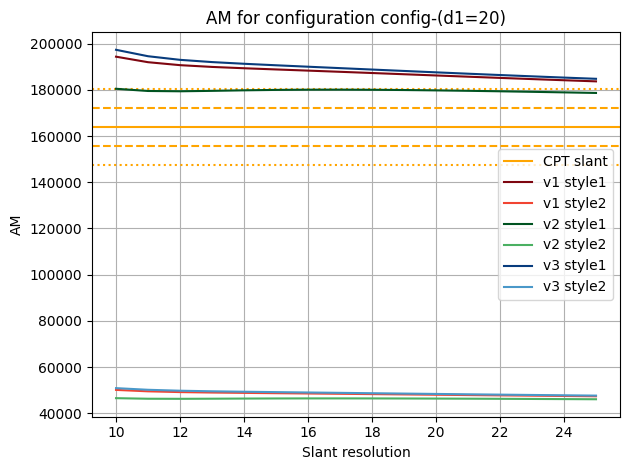

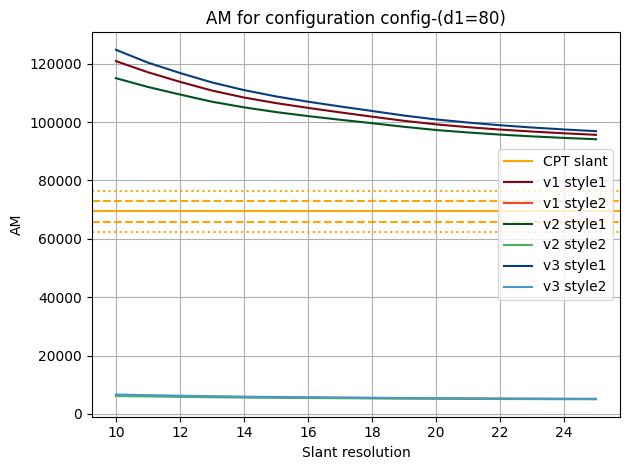

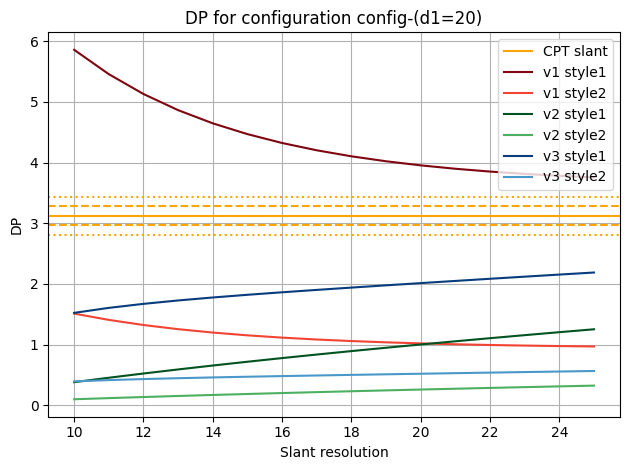

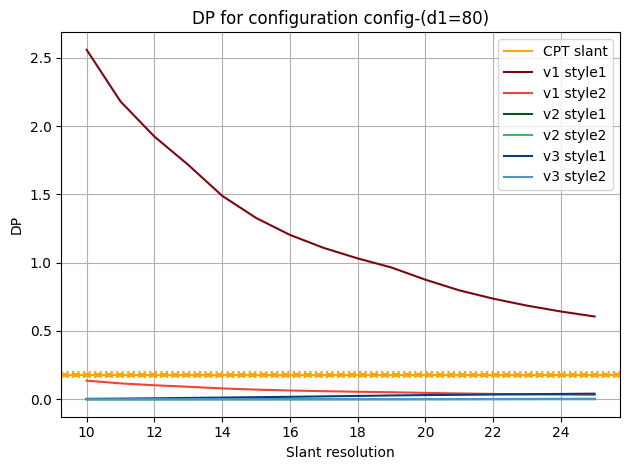

In [12]:
# For a single config, plot how each approximation varies with resolution.
def plot_wrt_res(config, coefficient):
  res_range = range(10, 26)
  x = list(res_range)

  margin1 = 0.05
  margin2 = 0.10

  meem_box = config["MEEM box "+ coefficient]
  cpt_box = config["MEEM box "+ coefficient]
  cpt_slant = config["CPT slant "+ coefficient]

  # plt.axhline(y = meem_box, color='blue', linestyle='-', label = "box ratio")
  # plt.axhline(y = cpt_box, color='black', linestyle='-', label = "CPT box")
  plt.axhline(y = cpt_slant, color='orange', linestyle='-', label = "CPT slant")
  plt.axhline(y = cpt_slant * (1 + margin1), color='orange', linestyle='--')
  plt.axhline(y = cpt_slant * (1 - margin1), color='orange', linestyle='--')
  plt.axhline(y = cpt_slant * (1 + margin2), color='orange', linestyle=':')
  plt.axhline(y = cpt_slant * (1 - margin2), color='orange', linestyle=':')

  versions = [1, 2, 3]
  styles = [1, 2]

  cmapr, cmapg, cmapb = get_cmap('Reds'), get_cmap('Greens'), get_cmap('Blues')
  interval = 0.7/(len(styles))
  colorr = [cmapr(0.95 - interval * i) for i in range(len(styles))]
  colorg = [cmapg(0.95 - interval * i) for i in range(len(styles))]
  colorb = [cmapb(0.95 - interval * i) for i in range(len(styles))]

  for version in versions:
    i = 0
    for style in styles:
      vals = [config["v"+ str(version) + " style" + str(style) + " " + coefficient + "s"][i - 1] for i in res_range]
      lab = ("v"+ str(version) + " style" + str(style))
      color = [colorr, colorg, colorb][version - 1]
      plt.plot(x, vals, color = color[i], label = lab)
      i += 1

  # Labels and title
  plt.xlabel('Slant resolution')
  plt.ylabel(coefficient)
  plt.title(coefficient + " for configuration " + config["name"])
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


for config in [configurations[3], configurations[15]]:
  plot_wrt_res(config, "AM")

for config in [configurations[3], configurations[15]]:
  plot_wrt_res(config, "DP")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_40293/344206908.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


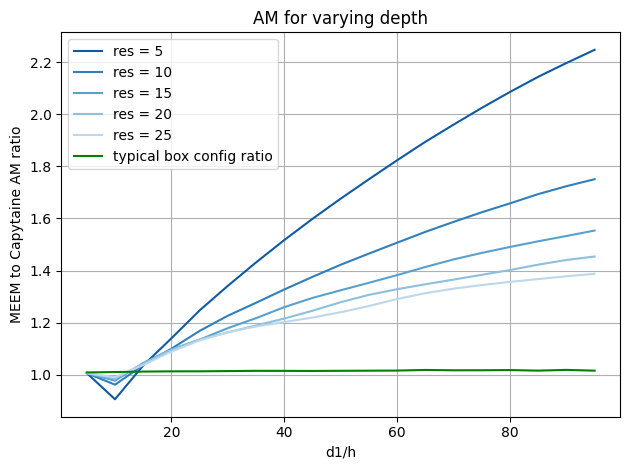

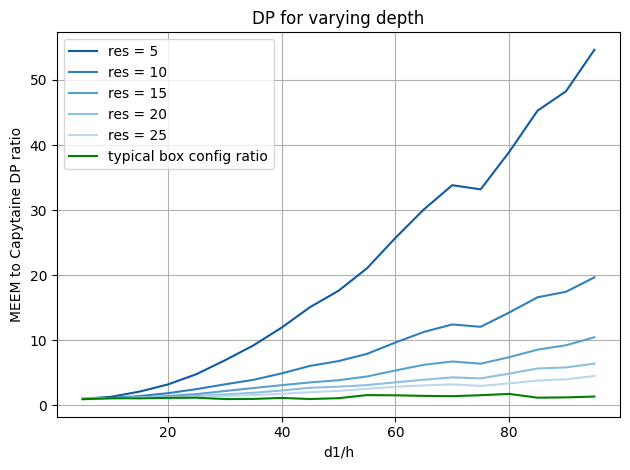

In [11]:
# Plot lines for res and depth for a single version and style
def plot_wrt_depth(configurations, version, style, coefficient):
  # coefficient = "AM" or "DP"
  x = list(range(5, 100, 5))

  meem_box_values = [config["MEEM box " + coefficient] for config in configurations]
  cpt_box_values = [config["CPT box " + coefficient] for config in configurations]
  cpt_slant_values = [config["CPT slant " + coefficient] for config in configurations]

  box_ratios = [a / b for a, b in zip(meem_box_values, cpt_box_values)]

  cmap = get_cmap('Blues')
  interval = 0.7/25
  colors = [cmap(0.95 - interval * i) for i in range(25)]

  for res in range(4, 25, 5):
    vals = [config["v"+ str(version) + " style" + str(style) + " " + coefficient + "s"][res] for config in configurations]
    y = [a / b for a, b in zip(vals, cpt_slant_values)]
    plt.plot(x, y, color = colors[res], label = "res = " + str(res + 1))

  plt.plot(x, box_ratios, label= 'typical box config ratio', color = "green", linestyle = "-")

  # Labels and title
  plt.xlabel('d1/h')
  plt.ylabel("MEEM to Capytaine " + coefficient + " ratio")
  plt.title(coefficient + " for varying depth")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


plot_wrt_depth(configurations, 2, 1, "AM")
plot_wrt_depth(configurations, 1, 1, "DP")

Case study for d1 = 80.

Will increasing resolution and/or NMK move convergence of any of the forms to an acceptable range?

Compute an even higher mesh-resolution for Capytaine.

In [ ]:
css = CapytaineSlantSolver(True, True, True, True, True)

In [ ]:
config0 = copy.deepcopy(configurations[15])
# t_densities = [60, 90]
# f_densities = [20, 240, 20]
# respack = css.construct_and_solve(config0["a"], config0["d_in"], config0["d_out"], config0["heaving"],
#                               t_densities, 280, config0["h"], config0["m0"], config0["rho"], 1, f_densities = f_densities)

# Panel Count = 24600

Panel Count:  24600


In [ ]:
config0["CPT slant AM new"] = 69296.94280312925 # (respack[0].added_mass)["Heave"]
config0["CPT slant DP new"] = 0.12071785020108175 # (respack[0].radiation_damping)["Heave"]

In [ ]:
print(config0["CPT slant AM new"], config0["CPT slant AM"])
print(config0["CPT slant DP new"], config0["CPT slant DP"])

69296.94280312925 69407.45434426554
0.12071785020108175 0.17936968315739565


: 

In [ ]:
for version in [1, 2, 3]:
  config0["v"+ str(version) + " probs new"] = []
  config0["v"+ str(version) + " xs new"] = []
  for res in range(30, 211, 30):
    prob, x = solve_prob(config, res, version)
    config0["v"+ str(version) + " probs new"].append(prob)
    config0["v"+ str(version) + " xs new"].append(x)
    print("finished res " + str(res))

finished res 30
finished res 60


In [ ]:
for version in [1, 2, 3]:
  config0["v"+ str(version) + " style1 AMs new"] = []
  config0["v"+ str(version) + " style1 DPs new"] = []
  for i in range(7):
    prob = config0["v"+ str(version) + " probs new"][i]
    x = config0["v"+ str(version) + " xs new"][i]
    am, dp = get_hydros(config0, prob, x, 1)
    config0["v"+ str(version) + " style1 AMs new"].append(am)
    config0["v"+ str(version) + " style1 AMs new"].append(dp)
  st = sin_theta(config)
  config0["v"+ str(version) + " style2 AMs new"] = [st * val for val in config0["v"+ str(version) + " style1 AMs new"]]
  config0["v"+ str(version) + " style2 DPs new"] = [st * val for val in config0["v"+ str(version) + " style1 DPs new"]]

In [ ]:
def plot_wrt_res_new(config, coefficient, res_range):
  res_range = range(30, 211, 30)
  x = list(res_range)

  margin1 = 0.05
  margin2 = 0.10

  meem_box = config["MEEM box "+ coefficient]
  cpt_box = config["MEEM box "+ coefficient]
  cpt_slant = config["CPT slant "+ coefficient]

  # plt.axhline(y = meem_box, color='blue', linestyle='-', label = "box ratio")
  # plt.axhline(y = cpt_box, color='black', linestyle='-', label = "CPT box")
  plt.axhline(y = cpt_slant, color='orange', linestyle='-', label = "CPT slant")
  plt.axhline(y = cpt_slant * (1 + margin1), color='orange', linestyle='--')
  plt.axhline(y = cpt_slant * (1 - margin1), color='orange', linestyle='--')
  plt.axhline(y = cpt_slant * (1 + margin2), color='orange', linestyle=':')
  plt.axhline(y = cpt_slant * (1 - margin2), color='orange', linestyle=':')

  versions = [1, 2, 3]
  styles = [1, 2]

  cmapr, cmapg, cmapb = get_cmap('Reds'), get_cmap('Greens'), get_cmap('Blues')
  interval = 0.7/(len(styles))
  colorr = [cmapr(0.95 - interval * i) for i in range(len(styles))]
  colorg = [cmapg(0.95 - interval * i) for i in range(len(styles))]
  colorb = [cmapb(0.95 - interval * i) for i in range(len(styles))]

  for version in versions:
    i = 0
    for style in styles:
      vals = [config["v"+ str(version) + " style" + str(style) + " " + coefficient + "s"][i] for i in range(len(res_range))]
      lab = ("v"+ str(version) + " style" + str(style))
      color = [colorr, colorg, colorb][version - 1]
      plt.plot(x, vals, color = color[i], label = lab)
      i += 1

  # Labels and title
  plt.xlabel('Slant resolution')
  plt.ylabel(coefficient)
  plt.title(coefficient + " for configuration " + config["name"])
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()